In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats.mstats import gmean
import time
import pylab as pl
from IPython import display

from pprint import pprint

In [2]:
float_formatter = "{0:0.2e}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [3]:
q = 5e-10 # esu, electron charge
m_e = 1e-27 # g, electron mass
c = 3e10 # cm/s, speed of light
cm2pc = 3.24077929e-19

prefactor = q**2 / (2*np.pi * m_e * c)

def estimate_DM(nu0, nu1, t0, t1):
    '''
    Inputs:
        nu0/1: Float. Frequencies (in Hz) of peaks.
        t0/1: Float. Time of arrival of the peaks.
    Returns:
        DM: An estimate of the dispersion measure (i.e. column density of electrons)
        in electrons/cm^2.
    '''
#     prefactor = 4140 * 1e6**2 * cm2pc
    prefactor = q**2 / (2*np.pi * m_e * c)
    DM = (t1-t0) / (prefactor * (1/nu1**2 - 1/nu0**2))
    return DM

<h1>2</h1>
<h2>2.1</h2>

Text(0.5,0,'Power [AU]')

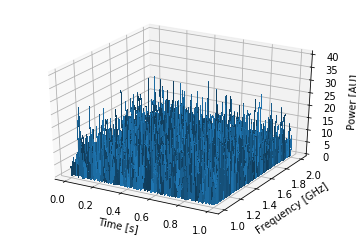

In [4]:
fname_pulsar = './pulsar.dat'

# Getting frequencies
with open(fname_pulsar) as f:
    column_headers = f.readlines()[0].strip().split('] [')
nu_vec = np.array([1e9*float(nu_str.replace('GHz', '').replace(']', '')) for nu_str in column_headers[1:]])

# Data
data_raw = np.loadtxt(fname_pulsar)

t_vec = data_raw[:,0]
t_mesh, nu_mesh = np.meshgrid(t_vec, nu_vec/1e9)
data_pulsar = data_raw[:,1:].transpose()

# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(t_mesh, nu_mesh, data_pulsar, linewidth=0, antialiased=False)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [GHz]')
ax.set_zlabel('Power [AU]')

# for i in range(0, 100, 10):
#     plt.figure()
#     plt.plot(t_vec, data_pulsar[i])
#     plt.title(f'{nu_vec[i]} GHz')

# Data too noisy for cross-correlations of raw data
# for d in data_pulsar[11:20]:
#     plt.figure()
#     cross_corr = np.convolve(data_pulsar[0], d[::-1], mode='same')
#     cross_corr_norm = cross_corr/max(cross_corr)
#     plt.plot(t_vec, cross_corr_norm)

# print(len(column_headers))
# print(len(set(column_headers)))
# print(column_headers.index('1.022 GHz'))
# print(column_headers[23])
# print(column_headers[24])

In [5]:
# Indices of top 2 peaks for a given frequency
idx_pk_dict = dict()
for i,nu in enumerate(nu_vec):
    idx_pk = np.argsort(data_pulsar[i])[::-1][0:2]
    idx_pk_dict[i] = idx_pk
    
# Filter to get (indices of) frequencies which have a single "clearly" distinguishable pulse
# (defined by a minimum difference in two max peaks' respective heights)
# The keys are the indices matching up to nu_vec.

# The threshold for what constitutes a single clearly distinguishable peak
diff_threshold_dict = {i:np.max(data_pulsar[i])*0.6 for i,_ in enumerate(nu_vec)}

# The difference between peaks at a given time
diff_pk_dict = {i:(data_pulsar[i][idx_pk[0]]-data_pulsar[i][idx_pk[1]]) for i,idx_pk in idx_pk_dict.items()}

# The indices (in nu_vec) for which the max is sufficiently large relative to other times in the same frequency
idx_pk_visible_vec = [i for i,v in diff_pk_dict.items() if v>=diff_threshold_dict[i]]

print(len(idx_pk_visible_vec))
# print(idx_pk_visible_vec)

7


<h3>Initial Estimate Method 1: Find the Time of Peak for a Given Frequency</h3>

Text(0.5,1,'Frequency = 2.0 GHz')

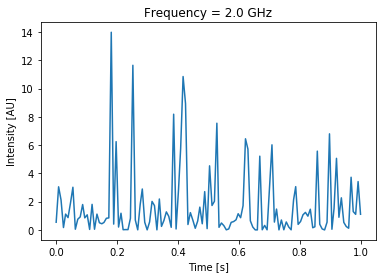

In [6]:
plt.plot(t_vec, data_pulsar[-1])
plt.xlabel('Time [s]')
plt.ylabel('Intensity [AU]')
plt.title(f'Frequency = {nu_vec[-1]*1e-9} GHz')

In [7]:
# Calculate a 2D array of dispersion measures DM where DM_ij = calculated dispersion
# measure between the indices i & j of two valid times 
# (i.e. times which had peaks which met the criteria for being 'big enough').
# Shave duplicates and the diagonal.
num_valid = len(idx_pk_visible_vec)
DM_array = np.zeros((num_valid, num_valid))*np.NAN
for i,idx0 in enumerate(idx_pk_visible_vec):
    for j,idx1 in enumerate(idx_pk_visible_vec):
        if i<=j:
            continue
        nu0 = nu_vec[idx0]
        nu1 = nu_vec[idx1]
        
        # Ignoring duplicated frequencies
        if nu0 == nu1:
            continue
            
        t0 = t_vec[np.argmax(data_pulsar[idx0])]
        t1 = t_vec[np.argmax(data_pulsar[idx1])]
        DM_array[i][j] = estimate_DM(nu0, nu1, t0, t1)
#         print(f'{"{0:2e}".format(nu0)}/{"{0:2e}".format(nu1)} -> {DM_array[i][j]}')
#         if DM_array[i][j] > 0:
#             plt.figure()
#             for n in (idx0, idx1):
#                 plt.plot(t_vec, data_pulsar[n], label=f'nu={"{0:.3f}".format(nu_vec[n]*1e-9)} GHz')
#                 plt.legend()
#                 plt.xlabel('Time [s]')
#                 plt.ylabel('Power [AU]')

pprint(DM_array)
DM_array_frequency = np.array(DM_array, copy=True)

array([[nan, nan, nan, nan, nan, nan, nan],
       [5.51e+20, nan, nan, nan, nan, nan, nan],
       [-1.57e+19, -5.00e+19, nan, nan, nan, nan, nan],
       [1.60e+21, 1.66e+21, 3.27e+22, nan, nan, nan, nan],
       [3.21e+20, 3.12e+20, 1.08e+21, -3.13e+21, nan, nan, nan],
       [6.14e+19, 4.50e+19, 1.63e+20, -2.23e+21, -1.12e+21, nan, nan],
       [6.59e+20, 6.63e+20, 1.55e+21, -7.40e+20, 2.19e+21, 4.64e+23, nan]])


<h3>Initial Estimate Method 2: Use Prior Knowledge (t=0 @ Start of Pulse Arrival)</h3>

Text(0,0.5,'Time of Peak [s]')

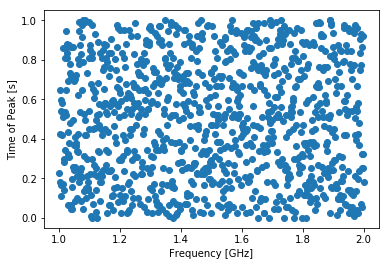

In [8]:
t_pk_vec = [t_vec[np.argmax(data_pulsar[i])] for i,_ in enumerate(nu_vec)]

plt.figure()
plt.plot(nu_vec*1e-9, t_pk_vec, 'o')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Time of Peak [s]')

There's not enough rhyme or reason to the above to comfortably throw something like least squares at the raw data.

In [9]:
DM_vec_frequency = []
for idx in idx_pk_visible_vec:
    nu0 = np.max(nu_vec)
    nu1 = nu_vec[idx]
    t0 = t_vec[np.argmax(data_pulsar[-1])]
    t1 = t_vec[np.argmax(data_pulsar[idx])]
    DM_vec_frequency.append(estimate_DM(nu0, nu1, t0, t1))
DM_vec_frequency = np.array(DM_vec_frequency)
pprint(DM_vec_frequency)

array([7.53e+20, 7.60e+20, 1.68e+21, -3.97e+20, 2.37e+21, 1.82e+22,
       3.21e+21])


General curiosity: You could rotate this and treat it as tracking a moving object (where the object's position is the the frequency of the peak) with variable acceleration, then throw an extended Kalman filter at it to figure out the DM with the initial estimate calculated using either of the methods above

<h2>2.2</h2>

In [10]:
n_e = .03 # electrons/cm^2

# Filtering out intentionally introduced NaNs and impossible DMs
# caused by noise overwhelming the real pulse
DM_vec =  DM_array_frequency.flatten() # DM_array_frequency.flatten()/DM_vec_frequency
DM_vec = DM_vec[~np.isnan(DM_vec)]
DM_vec = DM_vec[DM_vec > 0]
DM = gmean(DM_vec) # np.mean/median(DM_vec)
print(f'DM Estimate:\t\t{"{0:2e}".format(DM)} electrons/cm^2')

d = DM/n_e # cm
print(f'Distance Estimate:\t{"{0:2e}".format(d)} cm = {d*cm2pc} pc')

DM Estimate:		1.032229e+21 electrons/cm^2
Distance Estimate:	3.440765e+22 cm = 11150.758494193946 pc


<font color='red'>The value for distance seems high.</font>

<h2>2.3</h2>

In [11]:
omega_p = np.sqrt(4*np.pi * n_e * q**2 / m_e)
print(f'Plasma Frequency: {"{0:2e}".format(omega_p/(2*np.pi))} Hz')

Plasma Frequency: 1.545097e+03 Hz


<h2>2.4</h2>

In [12]:
sigma_Thomson = 8*np.pi/3 * (q**2/(m_e*c**2))**2
alpha_Thomson = n_e * sigma_Thomson
tau_Thomson = alpha_Thomson * d
print(f'Optical Depth: {tau_Thomson}')

Optical Depth: 0.0006672518908541399
